# Natural Language Processing with Disaster Tweets
---
雷智翔、林昊紳


In [56]:
# import 套件
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re ##regular expression library .
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer , TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [57]:
# Reading data
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [58]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## 資料種類

- id : a unique identifier for each tweet
- keyword : 一個關鍵詞，可能沒有
- location : tweet發出的地點，可能不知道
- text : tweet內容
- target : 這條tweet是否為真實災難，1 => true, 0 => false

In [59]:
# 看看整的資料集的狀況
train.info()
print()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [60]:
# 填補缺失值
for df in [train , test]:
    for e in ['keyword', 'location']:
        df[e] = df[e].fillna('NaN')

32.71 % 的tweets是真的
43.42 % 的tweets是假的

C:\Users\10288\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


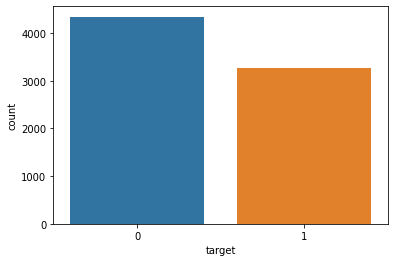

In [61]:
# 看一下所有tweets中的真實狀況
sns.countplot(
    train['target']
)
print(train[train['target']==1]['target'].count()/100,"% 的tweets是真的")
print(train[train['target']==0]['target'].count()/100,"% 的tweets是假的")
print()

C:\Users\10288\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\10288\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'length in each tweet')

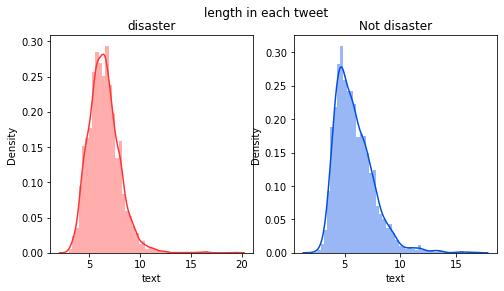

In [62]:
# 找出真實與假的tweets的text長度分布狀況
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))

txt=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(txt.map(lambda x: np.mean(x)),ax=ax2,color='#004de6')
ax2.set_title('Not disaster')


txt=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(txt.map(lambda x: np.mean(x)),ax=ax1,color='#ff3333')
ax1.set_title('disaster')

fig.suptitle('length in each tweet')

## 透過keyword觀察與target的關係


In [63]:
keyword=train.groupby('keyword')
keyword.size()

keyword
NaN                    61
ablaze                 36
accident               35
aftershock             34
airplane%20accident    35
                       ..
wounded                37
wounds                 33
wreck                  37
wreckage               39
wrecked                39
Length: 222, dtype: int64

Text(0.5, 1.0, 'Keyword and Target')

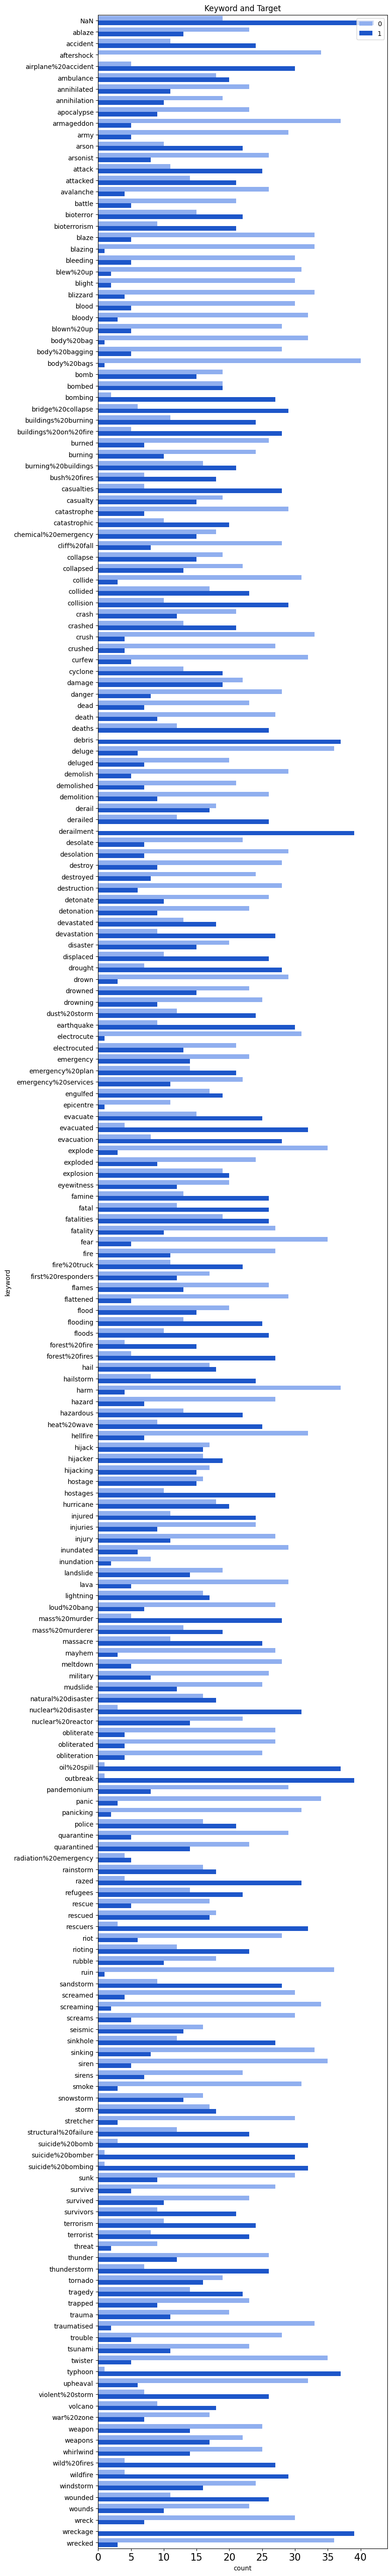

In [64]:
fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(
    y=train['keyword'],
    hue=train['target'] ,  palette= ["#80aaff","#004de6"]
)

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=10)
plt.legend(loc=1)

plt.title('Keyword and Target')

## 將text的長度新增為新的特性

In [65]:
train['length']=[len(n.split()) for n in train['text']]
train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16


## NLTK

In [66]:
nltk.download('wordnet')
nltk.download('stopwords')
stoplist = set(stopwords.words('english'))

test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))
test.head()
train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))
train.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\10288\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\10288\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16


In [67]:
# 清理資料
def Clean(text):
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text) #remove URL
    
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>') #remove special character 
    
    text = re.sub(r"(?:\@)\w+", '', text)
    text=text.encode("ascii",errors="ignore").decode()
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
   
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    
    text=" ".join(text.split())
    return text

In [68]:
train['text']=train['text'].apply(lambda x: Clean(x))
test['text']=test['text'].apply(lambda x: Clean(x))
train['text']

0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    The out of control wild fires in California ev...
7610              M194 [0104 UTC]?5km S of Volcano Hawaii
7611    Police investigating after an ebike collided w...
7612    The Latest More Homes Razed by Northern Califo...
Name: text, Length: 7613, dtype: object

## 利用TFIDF進行訓練預測
- TFIDF:分別表示詞頻（term frequency，tf）和逆向檔案頻率（inverse document frequency，idf）。是種將文字轉換為向量的方式。

In [69]:
## 切分資料
X_train, X_test, Y_train, Y_test = train_test_split(train['text'],train['target'],test_size = 0.3,random_state =87)

vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\b[a-zA-Z]{3,}\b' ,ngram_range=(1, 1))
vectorized = vectorizer.fit_transform(X_train)
temp=pd.DataFrame(
    vectorized.toarray(),
    columns=vectorizer.get_feature_names()
)

# X_train


In [70]:
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
trainfeature = tfidf.fit_transform(vectorized)

TFIDF= TfidfVectorizer(
    encoding='utf-8',
    ngram_range=(1,1),
    max_features=11000, 
    norm='l2',
    sublinear_tf =True
)



In [73]:
TrainFeat_= TFIDF.fit_transform(X_train)
TestFeat_ = TFIDF.transform(X_test)
classifier = MultinomialNB()
classifier.fit(TrainFeat_,Y_train)

test_pred= classifier.predict(TestFeat_)
accuracy = accuracy_score(Y_train, classifier.predict(TrainFeat_))
print('Accuracy:',accuracy)

Accuracy: 0.8785888534434227


In [72]:
result = pd.DataFrame()

tokenizer=TFIDF.transform( test['text']).toarray()

testPredict = classifier.predict(tokenizer)

result['id']=test['id']
result['target']=testPredict

result.to_csv('result.csv',index=False)

## 參考資料
https://www.kaggle.com/seungjo2/nlp-tweet-practice/notebook?select=test.csv 